# Exercises for Session 3

In [1]:
from __future__ import print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize

# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 18

In [2]:
# create 100 samples from a Normal distribution
# with mean 5 and standard deviation 1
np.random.seed(54321)
n = 100
m = 5
s = 1
d = stats.norm.rvs(m, s, size=n)

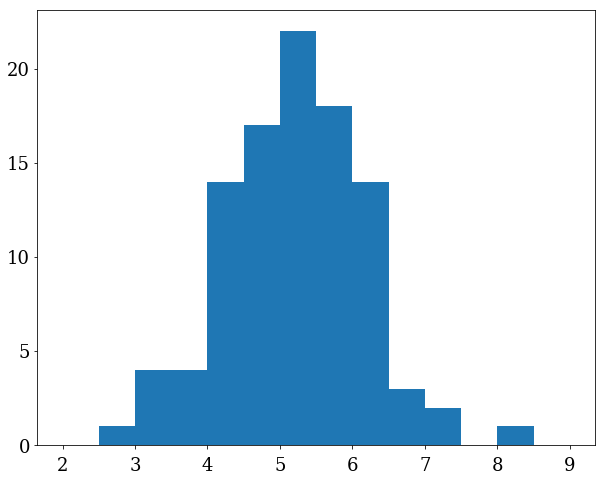

In [3]:
# histogram the data - this can be done with numpy,
# or simultaneously with plotting with pyplot
#hx, hy = numpy.histogram(d, bins=10)
hy, hx, p = plt.hist(d, bins=14, range=(2, 9), histtype='stepfilled')

In [4]:
# get the width of the bins and hence normalisation
w = hx[1]-hx[0]
a = n*w
# get the centres of the bins
hxc = 0.5*(hx[:-1] + hx[1:])

In [5]:
# returns the value of a Gaussian with specified amplitude,
# mean and sigma, evaluated at x (just for convenience)
def g(p, a, x):
    m, s = p
    return a * stats.norm.pdf(x, m, s)

In [6]:
# returns chisq of specified Gaussian for data (x, y)
def f(p, a, x, y):
    return ((y - g(p, a, x))**2).sum()

In [7]:
# find parameter set which minimises chisq
results = optimize.minimize(f, (3, 3), args=(a, hxc, hy))
results  # fit is unsuccessful!

      fun: 26.956195004031628
 hess_inv: array([[  5.71854390e-04,  -2.85524758e-05],
       [ -2.85524758e-05,   3.72381781e-04]])
      jac: array([ -1.66893005e-06,   4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 80
      nit: 15
     njev: 20
   status: 0
  success: True
        x: array([ 5.23848498,  0.92529815])

In [8]:
# Use a simpler method
results = optimize.minimize(f, (3, 3), args=(a, hxc, hy), method='Nelder-Mead')
results  # success!

 final_simplex: (array([[ 5.23846243,  0.92529616],
       [ 5.23851362,  0.92526338],
       [ 5.23846376,  0.92524291]]), array([ 26.95619547,  26.95619723,  26.95619967]))
           fun: 26.956195468242822
       message: 'Optimization terminated successfully.'
          nfev: 77
           nit: 40
        status: 0
       success: True
             x: array([ 5.23846243,  0.92529616])

In [9]:
# Specify parameter bounds
results = optimize.minimize(f, (3, 3), args=(a, hxc, hy), bounds=((None, None), (0.01, None)))
results  # success!

      fun: 26.956195004031894
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.52242671e-05,   5.43565193e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 13
   status: 0
  success: True
        x: array([ 5.238485  ,  0.92529817])

In [10]:
# Include parameter bounds in chisq function
def f(p, a, x, y):
    if s <= 0.0:
        return 1e99
    else:
        return ((y - g(p, a, x))**2).sum()
    
results = optimize.minimize(f, (3, 3), args=(a, hxc, hy))
results  # success!

      fun: 26.956195004031628
 hess_inv: array([[  5.71854390e-04,  -2.85524758e-05],
       [ -2.85524758e-05,   3.72381781e-04]])
      jac: array([ -1.66893005e-06,   4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 80
      nit: 15
     njev: 20
   status: 0
  success: True
        x: array([ 5.23848498,  0.92529815])

In [11]:
# get fit parameters
r1 = results.x

In [12]:
# use MLE method provided in stats (actually understands that this is samples from a distribution)
r2 = stats.norm.fit(d)

true function:  mean = 5.000, sigma = 1.000
optimize.fmin:  mean = 5.238, sigma = 0.925
stats.norm.fit: mean = 5.223, sigma = 0.939


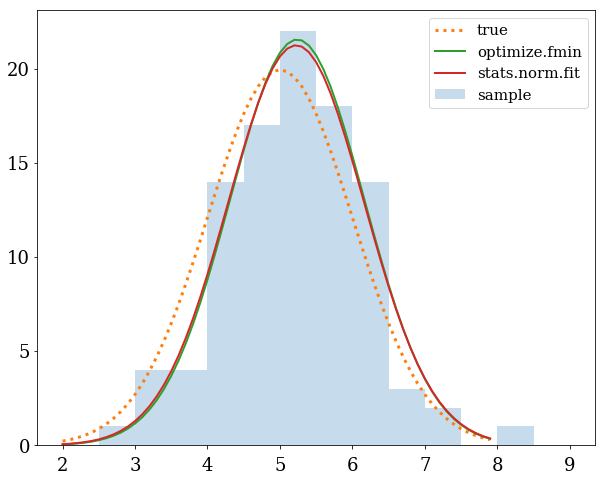

In [13]:
# plot true function and fit results over histogram
x = np.arange(m-3*s, m+3*s, s/10.0)
plt.hist(d, bins=hx, histtype='stepfilled', linestyle=None,
         alpha=0.25, label='sample')
plt.plot(x, g((m, s), a, x), ':', label='true', lw=3)
plt.plot(x, g(r1, a, x), label='optimize.fmin', lw=2)
plt.plot(x, g(r2, a, x), label='stats.norm.fit', lw=2)
plt.legend(prop={'size':'small'})

# neatly print results to screen
print('true function:  mean = {:5.3f}, sigma = {:5.3f}'.format(m, s))
print('optimize.fmin:  mean = {:5.3f}, sigma = {:5.3f}'.format(*r1))
print('stats.norm.fit: mean = {:5.3f}, sigma = {:5.3f}'.format(*r2))

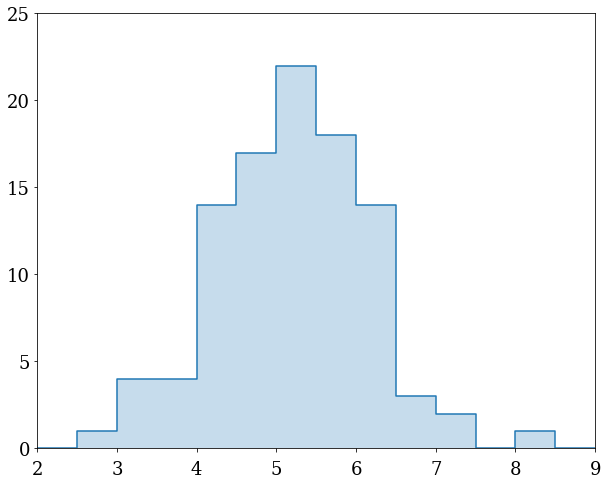

In [14]:
# Additional note:
# trick for drawing a binned function without original sample
# add zero bins at each end of distribution
hhxc = np.concatenate(([hxc[0]-w], hxc, [hxc[-1]+w]))
hhy = np.concatenate(([0], hy, [0]))
plt.plot(hhxc, hhy, drawstyle='steps-mid', label='sample')
plt.fill_between(hhxc, 0, hhy, step='mid', alpha=0.25)
_ = plt.axis(xmin=2, xmax=9, ymin=0, ymax=25)